## Motivating Example for Vector Optimization and VOPy
This notebook contains a basic example that motivates a vector optimization solution in two dimensional euclidean space, following that with what VOPy offers while other SOTA lacks.

In [36]:
import numpy as np
import torch
import botorch.utils.multi_objective.pareto

from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder
from vopy.datasets import get_dataset_instance

from vopy.utils.plotting import plot_pareto_front

set_seed(0)

### Pareto points and domination
Let's create an instance of a test dataset which has two objectives that we try to maximize. Assume we're trying the best sweet possible where the objectives are cheapness and taste. We can calculate its [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) using a popular Bayesian optimization tool called BoTorch, and visualize it. Here, cheapness would correspond to the $x$-axis and the taste would correspond to the $y$-axis.

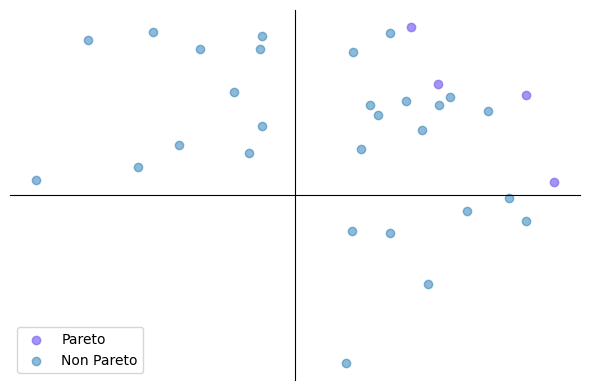

In [37]:
dataset_name = "Test"
dataset = get_dataset_instance(dataset_name)
pareto_front = botorch.utils.multi_objective.pareto.is_non_dominated(torch.tensor(dataset.out_data))
fig_pareto = plot_pareto_front(dataset.out_data, pareto_indices=pareto_front)

As you can see, there are multiple points (the 4 purple dot) that can not be compared with each other in our Pareto front. Some have higher cheapness but lower taste while others are more expensive but they taste better.

In most problems that has multiple objectives, similar to our case, there are several points constituting the Pareto front. These are selected according to not being `dominated` by any other point in any of the objectives. While the selection we visualized is a valid selection, it reflects only a specific domination definition that we are all familiar with, specifically the $\leq$ ordering. We'll call this the componentwise order for obvious reasons. The field working on this kind of optimization is called **multi-objective optimization**. We can examine this componentwise order and its domination relation within a generalized framework, *i.e.*, cones, by observing the following: a point belongs to the Pareto front if no other point is inside the first quadrant of a coordinate system that has that point as its origin. In the figure below, you can see this specific region traced. This region can be represented with a convex polyhedral cone.*

**: If you examine the code below, you can actually see that it is represented as a cone using VOPy. It is a special kind of cone as well, but let's not get ahead of ourselves.*

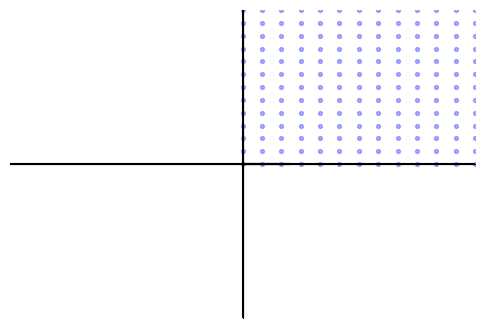

In [38]:
from vopy.ordering_cone import OrderingCone

dim = 2
componentwise_2d_ordering_cone = OrderingCone(W=np.eye(dim))
_ = componentwise_2d_ordering_cone.plot()

### Preferences?
At this point, the following question might arise: "Can we somehow encode preferences using this approach?". The answer is a clear yes. We will work through an example.

Let's say we would like to allow a tradeoff between our objectives, and say for example a slight decrease of cheapness is tolerable if we gain 2 times as much in taste. And let's say this tradeoff symmetrical for practicality purposes, meaning it is valid for decrease of taste and increase of cheapness. So, the cone for this region would have to be a bit wider on both axes, like the following.

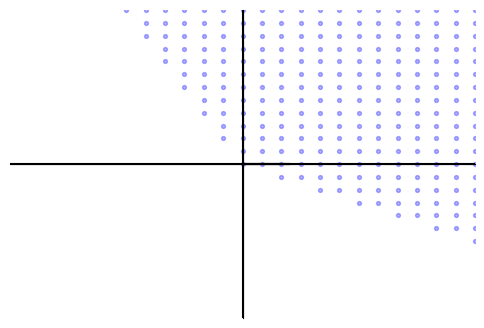

In [39]:
from vopy.utils import get_2d_w

trade_off_ratio = 1/2
angle_around_x_equal_y = np.rad2deg(np.pi/2 + 2*np.arctan(trade_off_ratio))
constraint_matrix = get_2d_w(angle_around_x_equal_y)
obtuse_2d_ordering_cone = OrderingCone(W=constraint_matrix)
_ = obtuse_2d_ordering_cone.plot()

OK. Now that we have defined how we want to choose our "best" points using a cone, allowing some tradeoff between objectives, we should find which sweets are actually Pareto*. Can we use the same function from BoTorch? Unfortunately, we can't. This is where the term **Vector Optimization** comes into play. It allows us to optimize functions considering the preferences defined by a cone. Cones induce partial orderings (like componentwise order), which can resolve domination relations that we've talked about and tell us which candidate is better.

VOPy comes into play at this point. VOPy gives the user to ability to define partial orderings and optimize the function at hand using these. Let's find our best sweets using the cone we created above with VOPy.

**: Note that Pareto optimality is originally defined for the componentwise order. We still call the best candidates under different partial orderings Pareto optimal as well noting the cone that is being considered, as it is convenient.*

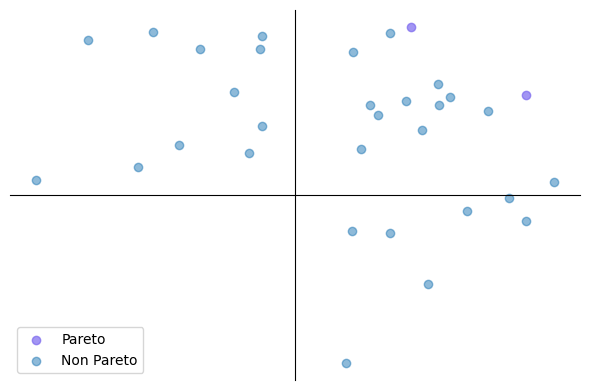

In [40]:
obtuse_2d_order = ConeTheta2DOrder(cone_degree=angle_around_x_equal_y)
_ = obtuse_2d_order.plot_pareto_set(dataset.out_data)

As our preference allowed some tradeoffs, it was easier to compare points so being best is harder. We now have only 2 sweets at hand! Yay!

Until now, we assumed known function values, so we knew the taste and cheapness of all sweets before starting our optimization procedure. If we didn't know the function, and the only information that we could get was the noisy function values at queried points, we would have to deal with black-box optimization. VOPy actually specializes on providing black-box vector optimization algorithms and an environment for development of black-box vector optimization algorithms.